# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Anwar Muslim
- **Email:** as2270319@gmail.com
- **ID Dicoding:** M119D5Y0248

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install -q tensorflowjs
import tensorflowjs as tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import shutil
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

## Data Preparation

In [10]:
from google.colab import files
import os
import shutil

files.upload()

os.makedirs("/root/.config/kaggle", exist_ok=True)
if os.path.exists("kaggle.json"):
    shutil.move("kaggle.json", "/root/.config/kaggle/kaggle.json")
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

!ls -l /root/.config/kaggle

Saving kaggle.json to kaggle.json
total 4
-rw------- 1 root root 63 Dec  1 13:09 kaggle.json


### Data Loading

In [11]:
# ============================================
# Cell 2 - Data Loading dari Kaggle
# ============================================
from pathlib import Path
import os
import zipfile
from PIL import Image

# 1. Konfigurasi dataset Kaggle
#    EDIT DATASET_SLUG jika kamu memakai dataset lain
DATASET_SLUG = "kausthubkannan/5-flower-types-classification-dataset"

DOWNLOAD_DIR = Path("/content/kaggle_download")  # tempat simpan file .zip
RAW_DIR      = Path("/content/dataset_raw")      # tempat ekstrak dataset mentah

DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)
RAW_DIR.mkdir(parents=True, exist_ok=True)

# 2. Pastikan package kaggle ter-install
!pip install -q kaggle

import kaggle  # di titik ini kaggle.json harus sudah ada di /root/.config/kaggle

# 3. Download dataset jika zip belum ada
zip_files = list(DOWNLOAD_DIR.glob("*.zip"))
if not zip_files:
    print(f"Mendownload dataset dari Kaggle: {DATASET_SLUG}")
    !kaggle datasets download -d {DATASET_SLUG} -p {DOWNLOAD_DIR.as_posix()}
    zip_files = list(DOWNLOAD_DIR.glob("*.zip"))
else:
    print("File ZIP sudah ada, skip download.")

print("File ZIP yang ditemukan:", [z.name for z in zip_files])

# 4. Ekstrak ke RAW_DIR (hanya jika belum berisi apa-apa)
if not any(RAW_DIR.iterdir()):
    print(f"Mengekstrak semua ZIP ke {RAW_DIR} ...")
    for z in zip_files:
        with zipfile.ZipFile(z, 'r') as zip_ref:
            zip_ref.extractall(RAW_DIR)
    print("Selesai ekstrak.")
else:
    print(f"Folder {RAW_DIR} sudah berisi data, skip ekstrak.")

# 5. Cari folder yang berisi subfolder kelas (misal: Lilly, Lotus, dsb.)
def find_class_root(root: Path) -> Path:
    candidates = []
    for dirpath, dirnames, filenames in os.walk(root):
        subdirs = [Path(dirpath) / d for d in dirnames]
        has_class_subdirs = False
        for sd in subdirs:
            image_files = [
                f for f in os.listdir(sd)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]
            if len(image_files) > 0:
                has_class_subdirs = True
                break
        if has_class_subdirs:
            candidates.append(Path(dirpath))

    if not candidates:
        raise RuntimeError(
            "Tidak menemukan folder berisi subfolder kelas di bawah "
            + str(root)
        )

    # Ambil folder terdalam (panjang path terbesar)
    candidates = sorted(candidates, key=lambda p: len(str(p)))
    return candidates[-1]

class_root = find_class_root(RAW_DIR)
print("Folder root kelas terdeteksi:", class_root)

# 6. Fungsi untuk cek jumlah gambar & resolusi
def print_images_resolution(directory: Path):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = directory / subdir
        if not subdir_path.is_dir():
            continue

        image_files = [
            f for f in os.listdir(subdir_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        num_images = len(image_files)
        print(f"{subdir}: {num_images} gambar")
        total_images += num_images

        for img_file in image_files:
            img_path = subdir_path / img_file
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
            except Exception as e:
                print(f"- Gagal membaca {img_path.name}: {e}")

    print("\nResolusi unik yang terdeteksi:")
    for size in unique_sizes:
        print(f"- {size}")
    print("---------------")
    print(f"Total gambar: {total_images}")

# 7. Jalankan cek jumlah gambar & resolusi
print_images_resolution(class_root)

# 8. Simpan root ini ke variabel yang dipakai cell berikutnya
raw_dir = class_root                  # dipakai untuk split train/val/test
base_dir = Path("/content/dataset")   # folder hasil split

print("\nraw_dir yang akan dipakai untuk split:", raw_dir)
print("base_dir:", base_dir)

Mendownload dataset dari Kaggle: kausthubkannan/5-flower-types-classification-dataset
Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset
License(s): other
 60% 145M/242M [00:00<00:00, 1.51GB/s]
100% 242M/242M [00:00<00:00, 955MB/s] 
File ZIP yang ditemukan: ['5-flower-types-classification-dataset.zip']
Mengekstrak semua ZIP ke /content/dataset_raw ...
Selesai ekstrak.
Folder root kelas terdeteksi: /content/dataset_raw/flower_images
Orchid: 1000 gambar
Tulip: 1000 gambar
Lilly: 999 gambar
Sunflower: 1000 gambar
Lotus: 1000 gambar

Resolusi unik yang terdeteksi:
- (313, 200)
- (1200, 1600)
- (315, 160)
- (419, 626)
- (580, 580)
- (1600, 1167)
- (720, 968)
- (612, 388)
- (334, 151)
- (280, 180)
- (1300, 990)
- (399, 280)
- (860, 346)
- (257, 196)
- (530, 291)
- (728, 455)
- (1500, 1200)
- (150, 335)
- (209, 241)
- (1200, 1024)
- (760, 380)
- (298, 169)
- (612, 365)
- (250, 250)
- (633, 280)
- (3000, 1200)
- (1366, 805)
- (500, 281)
- (201, 25

### Data Preprocessing

#### Split Dataset

In [18]:
# ============================================
# Cell 3 – Split dataset ke train / val / test
# ============================================
import os
import shutil
import random
from pathlib import Path

# raw_dir & base_dir dari hasil cell 2
raw_dir = Path("/content/dataset_raw/flower_images")  # root folder yang berisi folder kelas
base_dir = Path("/content/dataset")                   # folder tujuan hasil split

train_split = 0.7
val_split   = 0.15
test_split  = 0.15
assert abs(train_split + val_split + test_split - 1.0) < 1e-6

def split_dataset(raw_dir: Path, base_dir: Path,
                  train_split: float, val_split: float, test_split: float,
                  seed: int = 42):
    if not raw_dir.exists():
        raise ValueError(f"Folder {raw_dir} tidak ditemukan.")

    random.seed(seed)

    # Hapus folder base_dir kalau mau mulai dari nol
    if base_dir.exists():
        print(f"Menghapus folder {base_dir} agar split ulang dari awal...")
        shutil.rmtree(base_dir)

    # Buat folder train/val/test
    for split_name in ["train", "val", "test"]:
        (base_dir / split_name).mkdir(parents=True, exist_ok=True)

    # Proses per kelas
    for class_name in os.listdir(raw_dir):
        class_dir = raw_dir / class_name
        if not class_dir.is_dir():
            continue

        images = [
            f for f in os.listdir(class_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_split)
        n_val   = int(n_total * val_split)
        n_test  = n_total - n_train - n_val

        print(f"Kelas: {class_name}")
        print(f"  Total: {n_total}, train: {n_train}, val: {n_val}, test: {n_test}")

        splits = {
            "train": images[:n_train],
            "val":   images[n_train:n_train + n_val],
            "test":  images[n_train + n_val:],
        }

        for split_name, split_files in splits.items():
            split_class_dir = base_dir / split_name / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)
            for fname in split_files:
                src = class_dir / fname
                dst = split_class_dir / fname
                shutil.copy2(src, dst)

    print("\nSelesai melakukan split dataset.")

# JALANKAN SPLIT SEKALI SAJA
RUN_SPLIT = True  # ubah ke False setelah split selesai agar tidak mengulang

if RUN_SPLIT:
    split_dataset(raw_dir, base_dir, train_split, val_split, test_split)
else:
    print("RUN_SPLIT = False, skip split dataset.")

print("\nStruktur folder /content/dataset:")
!ls -R /content/dataset

Kelas: Orchid
  Total: 1000, train: 700, val: 150, test: 150
Kelas: Tulip
  Total: 1000, train: 700, val: 150, test: 150
Kelas: Lilly
  Total: 999, train: 699, val: 149, test: 151
Kelas: Sunflower
  Total: 1000, train: 700, val: 150, test: 150
Kelas: Lotus
  Total: 1000, train: 700, val: 150, test: 150

Selesai melakukan split dataset.

Struktur folder /content/dataset:
/content/dataset:
test  train  val

/content/dataset/test:
Lilly  Lotus  Orchid  Sunflower  Tulip

/content/dataset/test/Lilly:
00f36a3c40.jpg	 325d1de8f7.jpg  6696318393.jpg  a757fa785c.jpg  d4d19761df.jpg
01998d6fb5.jpg	 336f11c70d.jpg  6713fd7f88.jpg  abeefc4eb8.jpg  d57283a955.jpg
02be2ca388.jpg	 3373be4bcd.jpg  6eb1825b00.jpg  ae85e30e8e.jpg  d5c25a30b6.jpg
05b341b09f.jpg	 34529000cc.jpg  73c4147071.jpg  af921f09dc.jpg  d638a4571f.jpg
079f3fa65a.jpg	 36202ad0aa.jpg  74308a6033.jpg  aff73bb9b9.jpg  d74fc35be5.jpg
08733b7c68.jpg	 3aa55837fd.jpg  763a1228e0.jpg  b0680edccf.jpg  d8516f7e87.jpg
0da98adfa1.jpg	 3dae2a071

In [19]:
# Parameter gambar dan training
img_height = 180
img_width  = 180
batch_size = 32
seed       = 42

train_dir = base_dir / "train"
val_dir   = base_dir / "val"
test_dir  = base_dir / "test"

print("train_dir:", train_dir, " -> ada?:", train_dir.exists())
print("val_dir  :", val_dir,   " -> ada?:", val_dir.exists())
print("test_dir :", test_dir,  " -> ada?:", test_dir.exists())

# Membuat dataset TF dari folder
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=seed,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=seed,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Kelas:", class_names)
print("Jumlah kelas:", num_classes)

# Optimasi performance (cache & prefetch)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation (hanya untuk train)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

train_dir: /content/dataset/train  -> ada?: True
val_dir  : /content/dataset/val  -> ada?: True
test_dir : /content/dataset/test  -> ada?: True
Found 3499 files belonging to 5 classes.
Found 749 files belonging to 5 classes.
Found 751 files belonging to 5 classes.
Kelas: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
Jumlah kelas: 5


## Modelling

In [20]:
# Membangun arsitektur model CNN menggunakan Sequential

input_shape = (img_height, img_width, 3)

model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        data_augmentation,
        layers.Rescaling(1.0 / 255),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ],
    name="cnn_sequential_model"
)

model.summary()

# Kompilasi model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Training model
epochs = 20  # Silakan dinaikkan kalau akurasi belum mencapai ≥ 85%

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Evaluasi pada test set untuk melihat akurasi generalisasi
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss    : {test_loss:.4f}")

Model: "cnn_sequential_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,023,877 (30.61 MB)

 Trainable params: 8,023,877 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.3655 - loss: 1.4976 - val_accuracy: 0.5381 - val_loss: 1.1481
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.5658 - loss: 1.0684 - val_accuracy: 0.5941 - val_loss: 1.0123
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6197 - loss: 0.9808 - val_accuracy: 0.6368 - val_loss: 0.9275
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6283 - loss: 0.9475 - val_accuracy: 0.6515 - val_loss: 0.9202
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6509 - loss: 0.8882 - val_accuracy: 0.6796 - val_loss: 0.8713
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6698 - loss: 0.8295 - val_accuracy: 0.6716 - val_loss: 0.8626
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7043 - loss: 0.7692 - val_accuracy: 0.6796 - val_loss: 0.8341
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7180 - loss: 0.7141 - val_acc

## Evaluasi dan Visualisasi

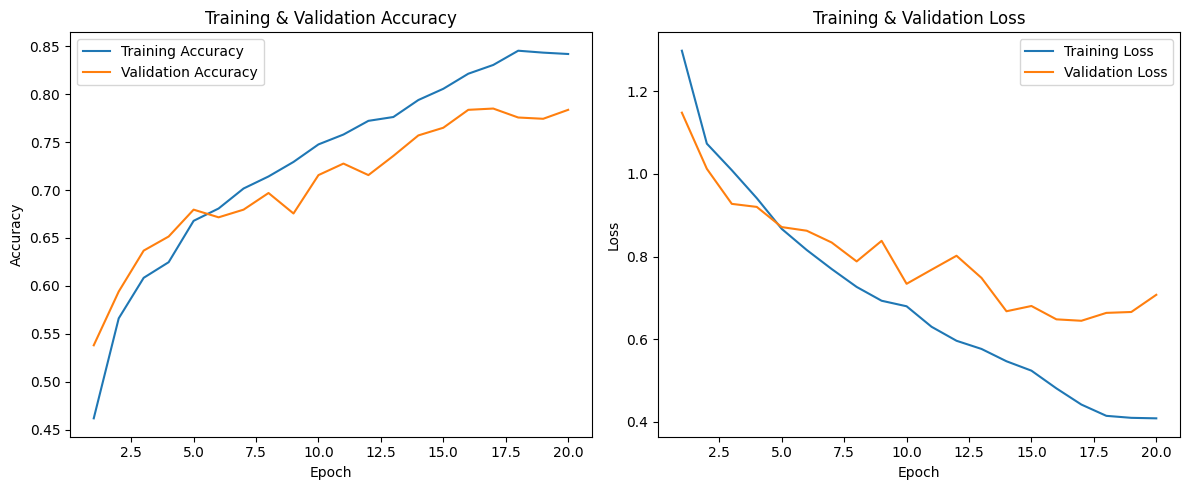

In [21]:
# Plot akurasi dan loss selama training

acc      = history.history["accuracy"]
val_acc  = history.history["val_accuracy"]
loss     = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [25]:
# ============================================
# Cell 6 – Konversi Model:
# SavedModel, TFLite, TFJS
# ============================================
from pathlib import Path
import shutil
import tensorflow as tf
import tensorflowjs as tfjs

# Asumsi: variabel `model` (hasil training) dan `class_names` sudah ada
# Input model: (180, 180, 3) sesuai yang muncul di log SavedModel

saved_model_dir = Path("saved_model")
tflite_dir      = Path("tflite")
tfjs_dir        = Path("tfjs_model")

# Bersihkan folder lama kalau ada
for d in [saved_model_dir, tflite_dir, tfjs_dir]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

# 1) EXPORT SavedModel dari model lengkap (dengan data_augmentation)
model.export(saved_model_dir.as_posix())
print("SavedModel diexport ke:", saved_model_dir.resolve())

# 1b) Buat model khusus inference TANPA data_augmentation
#     Asumsi arsitektur Sequential:
#     [0] data_augmentation
#     [1] Rescaling
#     [2..] Conv/Pool/Flatten/Dense
input_infer = tf.keras.Input(shape=(180, 180, 3))

x = model.layers[1](input_infer)   # lewati layer[0] (data_augmentation)
for layer in model.layers[2:]:
    x = layer(x)

inference_model = tf.keras.Model(input_infer, x, name="cnn_inference_model")
print("\nRingkasan model inference (tanpa augmentasi):")
inference_model.summary()

# 2) TFLite – konversi dari model inference (tanpa op random / transform kompleks)
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)

# Kalau ingin ukuran kecil bisa tambahkan optimizations:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_model_path = tflite_dir / "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("\nModel TFLite disimpan di:", tflite_model_path.resolve())

# Simpan label.txt untuk TFLite (nama kelas per baris)
label_txt_path = tflite_dir / "label.txt"
with open(label_txt_path, "w") as f:
    for name in class_names:
        f.write(name + "\n")
print("label.txt disimpan di:", label_txt_path.resolve())

# 3) TFJS – simpan dari model inference (tanpa data_augmentation)
tfjs.converters.save_keras_model(inference_model, tfjs_dir.as_posix())
print("Model TFJS disimpan di folder:", tfjs_dir.resolve())

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134284460147344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460148112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460148688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460149648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460150416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460151376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460149840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460151568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460152336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460154064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460152528: Te

Model: "cnn_inference_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,023,877 (30.61 MB)

 Trainable params: 8,023,877 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

Saved artifact at '/tmp/tmp0o5a8gq5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134284460149648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460150416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460151376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460149840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460151568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460152336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460154064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460152528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460154448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134284460154256: TensorSpec(shape=(), dtype=tf.resource, name=None)



Model TFLite disimpan di: /content/tflite/model.tflite
label.txt disimpan di: /content/tflite/label.txt
failed to lookup keras version from the file,
    this is likely a weight only file
Model TFJS disimpan di folder: /content/tfjs_model


## Inference (Optional)

In [44]:
def load_and_preprocess_image(img_path, img_height, img_width):
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # (1, H, W, 3)
    img_array = img_array / 255.0
    return img_array

sample_img_path = list(test_dir.rglob("*.jpg"))[700]  # ambil salah satu otomatis
print("Contoh gambar untuk inference:", sample_img_path)

img_tensor = load_and_preprocess_image(sample_img_path, img_height, img_width)
pred = model.predict(img_tensor)
pred_class_idx = np.argmax(pred[0])
pred_class_name = class_names[pred_class_idx]

print("Predicted class:", pred_class_name)
print("Probabilities:", pred[0])

Contoh gambar untuk inference: /content/dataset/test/Lotus/0e8428ce72.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: Lotus
Probabilities: [2.795487e-01 4.120350e-01 8.797228e-03 3.802284e-04 2.992388e-01]


In [45]:
# Membuat file requirements.txt dari environment saat ini
!pip freeze > requirements.txt

# Cek beberapa baris teratas untuk memastikan sudah terbentuk
!echo "requirements.txt created, preview:"
!head -n 40 requirements.txt

requirements.txt created, preview:
absl-py==1.4.0
accelerate==1.12.0
access==1.1.9
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.11.24.0.39.11
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.6
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.29.1
bigquery-magics==0.10.3
bleach==6.3.0
